<a href="https://colab.research.google.com/github/Ianmzi/ECG/blob/main/analisis_tf_ecgipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ewtpy

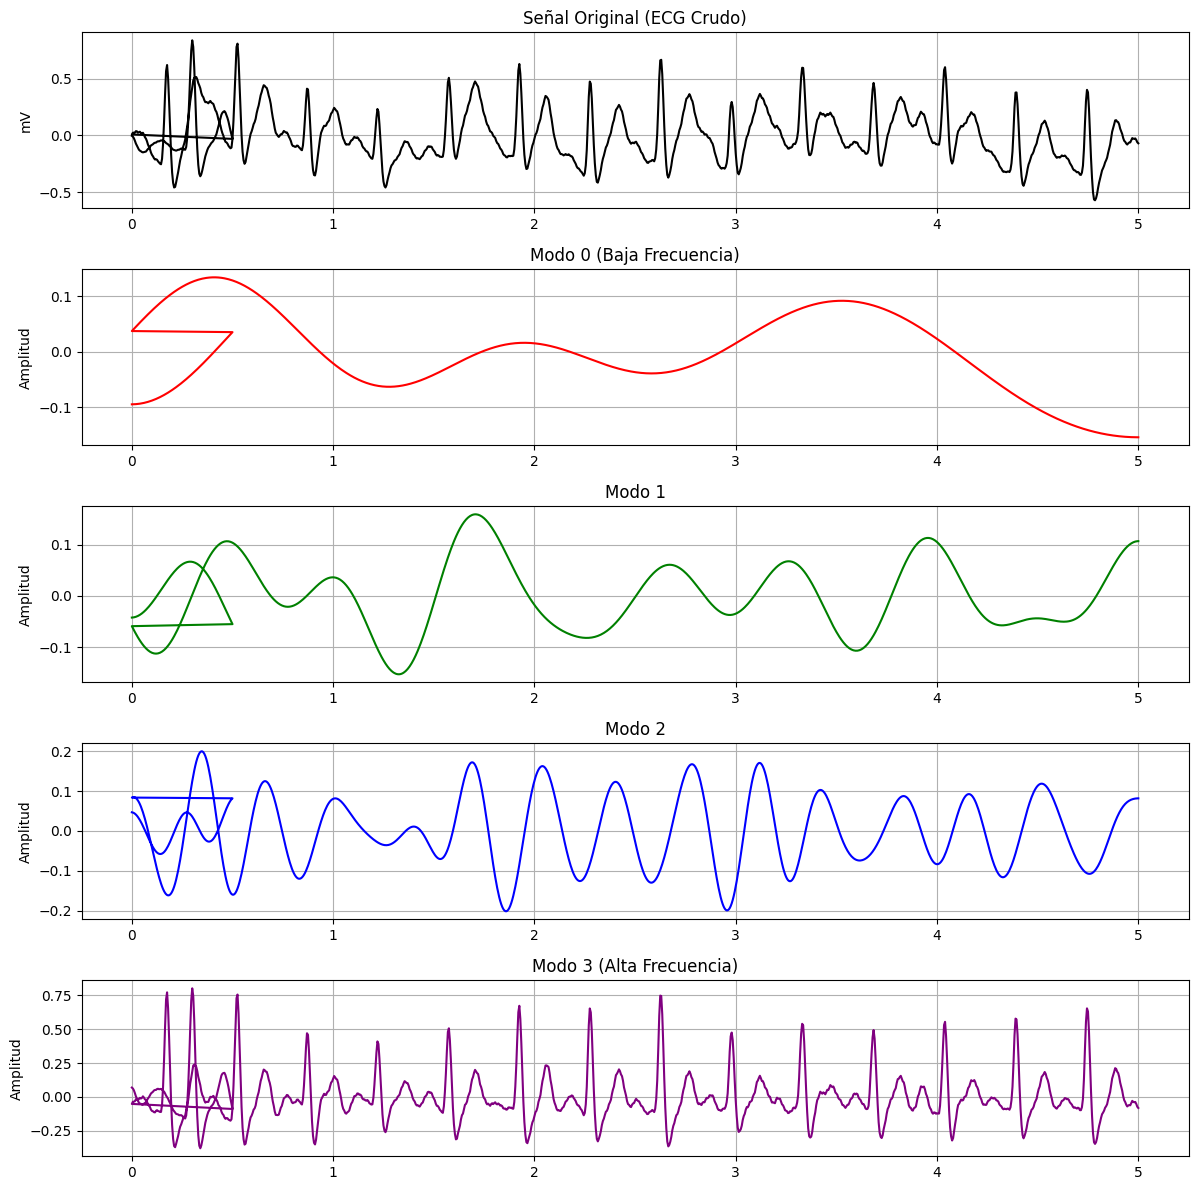

Fronteras detectadas (en frecuencia normalizada): [0.02280648 0.0570162  0.13398807]


In [4]:
# 1. CARGA DE DATOS (Método Robusto)
# ----------------------------------
filename = 'ecg2.txt'   # MD S14
header_line = 0
with open(filename, 'r') as f:
    for i, line in enumerate(f):
        if "Time" in line and "EKG" in line:
            header_line = i
            break

df = pd.read_csv(filename, delimiter='\t', skiprows=header_line)
df.columns = [c.strip() for c in df.columns]

# Limpieza de unidades y conversión
if pd.to_numeric(df['Time'].iloc[0], errors='coerce') is np.nan:
    df = df.drop(0)
df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
df['EKG'] = pd.to_numeric(df['EKG'], errors='coerce')
df = df.dropna(subset=['Time', 'EKG']).reset_index(drop=True)

# Tomamos 5 segundos para visualizar claro
df_zoom = df[df['Time'] <= 5.0]
signal = df_zoom['EKG'].values
time = df_zoom['Time'].values

# 2. APLICACIÓN DE EWT
# --------------------
# Solicitamos N=4 modos. El algoritmo buscará las 4 mejores bandas.
# ewt: matriz con los modos (columnas)
# mra: análisis multirresolución (no lo usaremos por ahora)
# boundaries: las fronteras de frecuencia que detectó automáticamente
ewt, mra, boundaries = ewtpy.EWT1D(signal, N=4)

# 3. VISUALIZACIÓN DE LOS MODOS
# -----------------------------
plt.figure(figsize=(12, 12))

# Señal Original
plt.subplot(5, 1, 1)
plt.plot(time, signal, 'black', linewidth=1.5)
plt.title('Señal Original (ECG Crudo)')
plt.grid(True)
plt.ylabel('mV')

# Graficar cada modo por separado
colors = ['red', 'green', 'blue', 'purple']
labels = ['Modo 0 (Baja Frecuencia)', 'Modo 1', 'Modo 2', 'Modo 3 (Alta Frecuencia)']

for i in range(4):
    plt.subplot(5, 1, i+2)
    plt.plot(time, ewt[:, i], color=colors[i])
    plt.title(labels[i])
    plt.grid(True)
    plt.ylabel('Amplitud')

plt.tight_layout()
plt.savefig('Separación de modos')
plt.show()

print("Fronteras detectadas (en frecuencia normalizada):", boundaries)

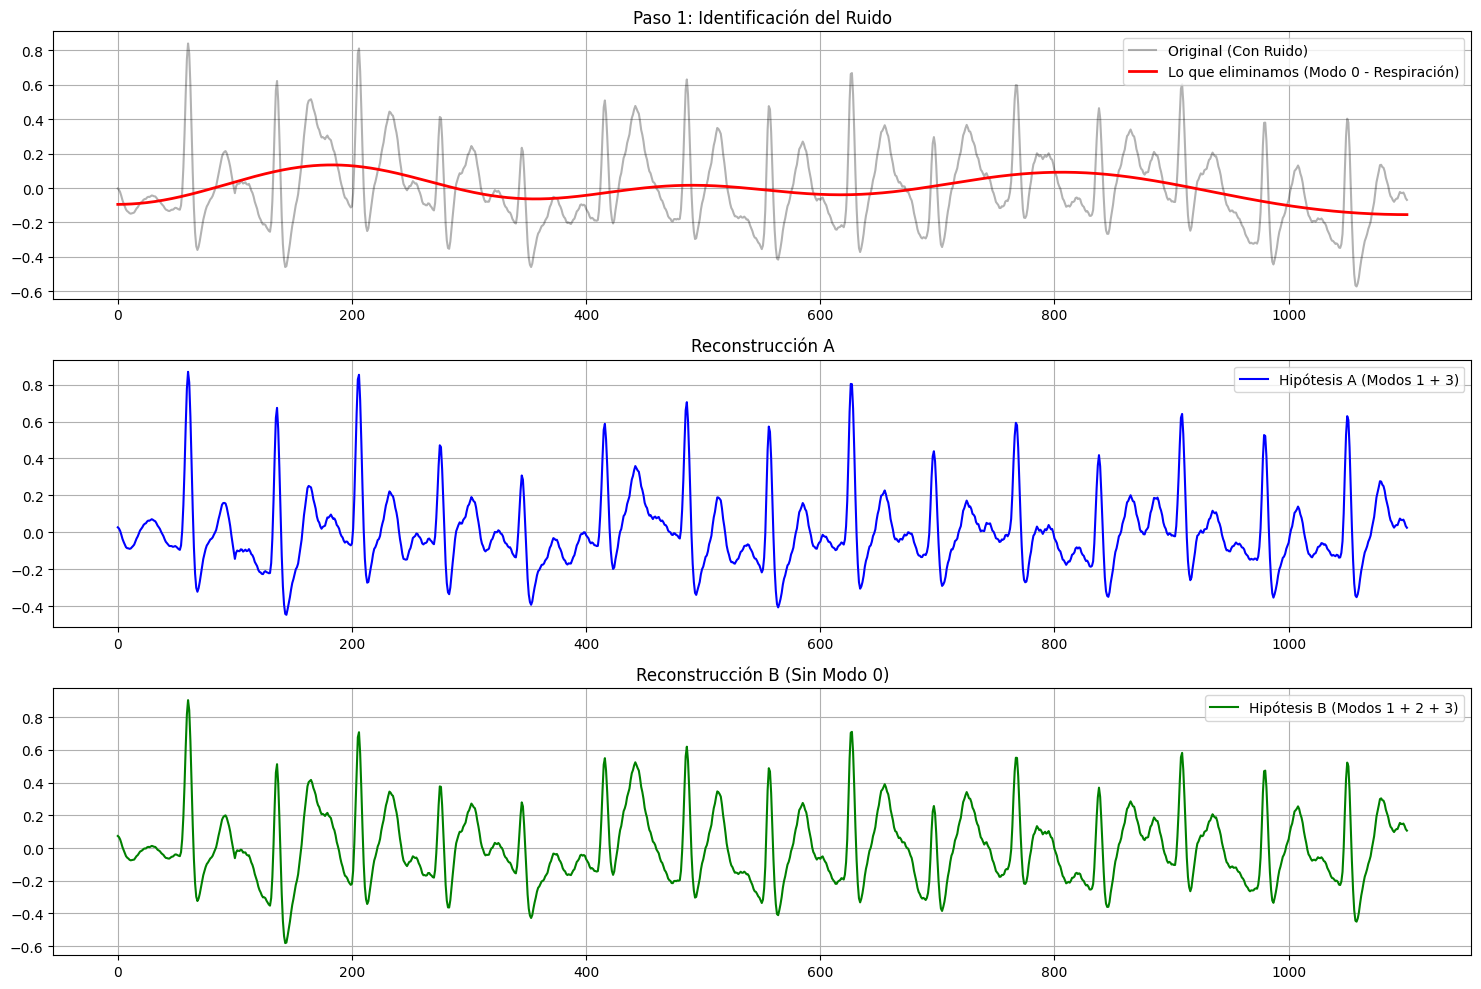

In [5]:
# 1. Construir las señales candidatas
# -----------------------------------

# Hipótesis A (La tuya): Modo 1 + Modo 3
# Nota: A veces el Modo 3 es muy pequeño, sumamos para ver.
rec_hipotesis_A = ewt[:, 1] + ewt[:, 3]

# Hipótesis B (La mía estándar): Modo 1 + Modo 2 + Modo 3 (Todo menos la respiración)
# A menudo la energía del QRS se reparte entre el 1 y el 2.
rec_hipotesis_B = ewt[:, 1] + ewt[:, 2] + ewt[:, 3]

# 2. Graficar para decidir el ganador
# -----------------------------------
plt.figure(figsize=(15, 10))

# Original
plt.subplot(3, 1, 1)
plt.plot(signal, color='black', alpha=0.3, label='Original (Con Ruido)')
plt.plot(ewt[:, 0], color='red', linewidth=2, label='Lo que eliminamos (Modo 0 - Respiración)')
plt.legend(loc='upper right')
plt.title('Paso 1: Identificación del Ruido')
plt.grid(True)

# Hipótesis A
plt.subplot(3, 1, 2)
plt.plot(rec_hipotesis_A, color='blue', label='Hipótesis A (Modos 1 + 3)')
plt.legend(loc='upper right')
plt.title('Reconstrucción A')
plt.grid(True)

# Hipótesis B
plt.subplot(3, 1, 3)
plt.plot(rec_hipotesis_B, color='green', label='Hipótesis B (Modos 1 + 2 + 3)')
plt.legend(loc='upper right')
plt.title('Reconstrucción B (Sin Modo 0)')
plt.grid(True)

plt.tight_layout()
plt.show()

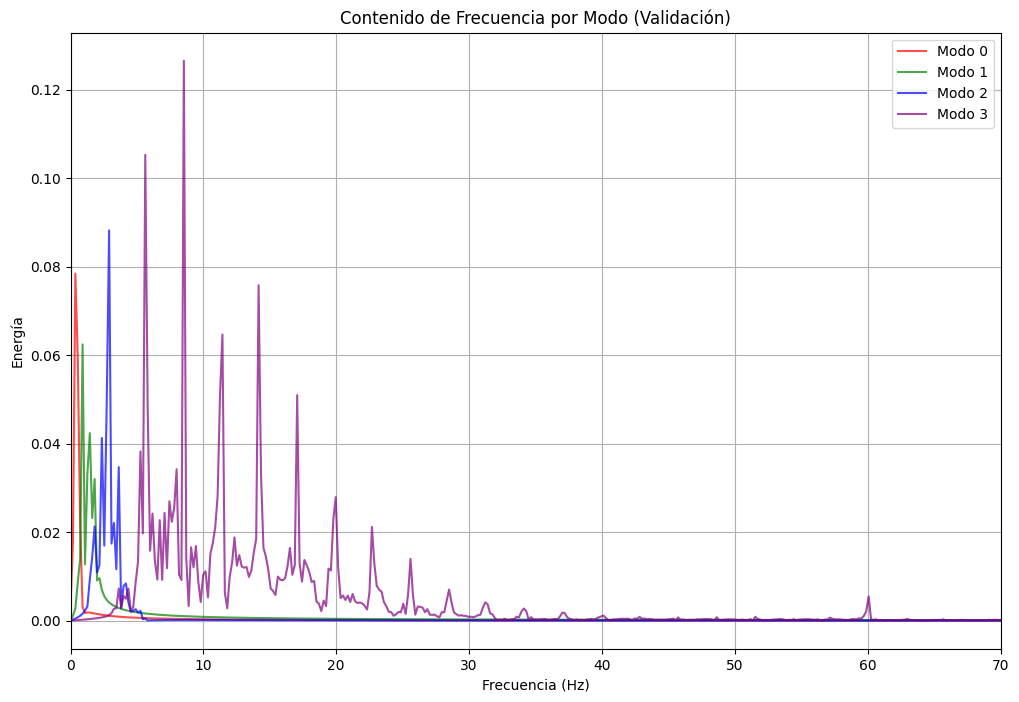

In [8]:
from scipy.fft import fft, fftfreq

# --- VALIDACIÓN ESPECTRAL DE MODOS ---
# Objetivo: Verificar científicamente qué contiene cada modo antes de sumar/restar

# Definir la frecuencia de muestreo (fs)
# El muestreo es de 0.005 segundos, por lo que fs = 1 / 0.005 = 200 Hz
fs = 1 / (df_zoom['Time'].iloc[1] - df_zoom['Time'].iloc[0])

plt.figure(figsize=(12, 8))
colores = ['red', 'green', 'blue', 'purple']

for i in range(4): # Asumiendo 4 modos
    # Calcular FFT de cada modo individual
    yf_modo = fft(ewt[:, i])
    xf_modo = fftfreq(len(ewt), 1/fs)[:len(ewt)//2]
    amp_modo = 2.0/len(ewt) * np.abs(yf_modo[0:len(ewt)//2])

    plt.plot(xf_modo, amp_modo, color=colores[i], label=f'Modo {i}', alpha=0.7)

plt.title('Contenido de Frecuencia por Modo (Validación)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Energía')
plt.xlim(0, 70) # Vemos hasta 70Hz para buscar el ruido de 60Hz
plt.legend()
plt.grid(True)
plt.show()

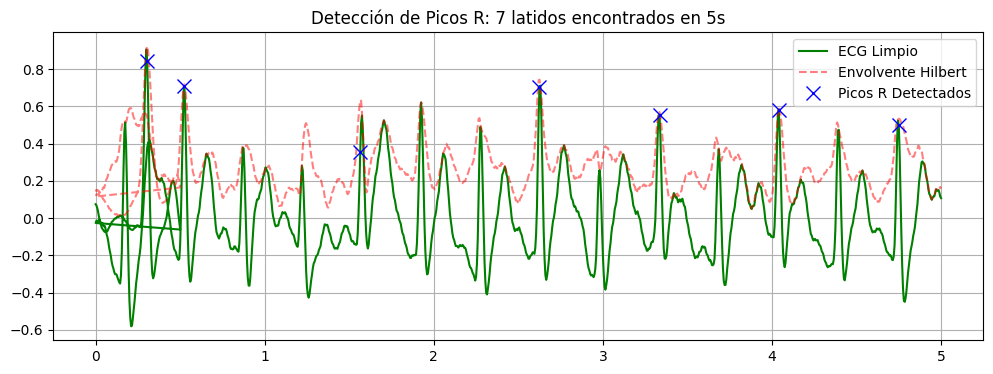

In [11]:
from scipy.signal import find_peaks, hilbert
import numpy as np
import matplotlib.pyplot as plt

# Asumimos que 'senal_limpia' es la reconstrucción B (sin el modo de baja frecuencia/respiración)
senal_limpia = rec_hipotesis_B

# Calcular la envolvente de Hilbert
envolvente = np.abs(hilbert(senal_limpia))

# Usamos la envolvente de Hilbert que ya calculaste
# Umbral: al menos 50% de la altura máxima de la envolvente (ajustable)
umbral_altura = np.max(envolvente) * 0.5
# Distancia: al menos 0.4 segundos entre latidos (para evitar falsos positivos)
distancia_min = int(0.4 * fs)

picos_indices, _ = find_peaks(envolvente, height=umbral_altura, distance=distancia_min)
tiempos_picos = df_zoom['Time'].iloc[picos_indices].values

# Graficar para confirmar
plt.figure(figsize=(12, 4))
plt.plot(df_zoom['Time'], senal_limpia, 'g', label='ECG Limpio')
plt.plot(df_zoom['Time'], envolvente, 'r--', alpha=0.5, label='Envolvente Hilbert')
plt.plot(tiempos_picos, senal_limpia[picos_indices], 'bx', markersize=10, label='Picos R Detectados')
plt.title(f'Detección de Picos R: {len(tiempos_picos)} latidos encontrados en 5s')
plt.legend()
plt.grid()
plt.show()

### Explanation of Spectral Analysis Code (Cell `id83tvSsT2Gq`)

This code block performs a spectral analysis on each of the modes obtained from the Empirical Wavelet Transform (EWT). The main objective is to scientifically verify the frequency content of each mode before they are combined or removed, ensuring a data-driven approach to signal reconstruction.

Here's a breakdown of the steps:

1.  **Import Libraries**: It imports `fft` and `fftfreq` from `scipy.fft` for Fast Fourier Transform operations, and `matplotlib.pyplot` for plotting.

2.  **Define Sampling Frequency (`fs`)**:
    *   The code calculates the sampling frequency (`fs`) based on the time difference between consecutive samples in `df_zoom['Time']`. This is crucial for correctly converting the FFT output from sample indices to actual frequencies (Hz).
    *   `fs = 1 / (df_zoom['Time'].iloc[1] - df_zoom['Time'].iloc[0])` determines that the sampling rate is 200 Hz, meaning 200 samples per second.

3.  **Initialize Plot and Colors**: A figure for plotting is created, and a list of `colores` (colors) is defined to differentiate the spectral plots of each mode.

4.  **Iterate Through Modes**: A `for` loop iterates through each of the 4 EWT modes (from 0 to 3).

5.  **Calculate FFT for Each Mode**:
    *   `yf_modo = fft(ewt[:, i])`: The Fast Fourier Transform (FFT) is applied to each mode (`ewt[:, i]`) to transform the signal from the time domain to the frequency domain. `yf_modo` contains the complex-valued FFT output.
    *   `xf_modo = fftfreq(len(ewt), 1/fs)[:len(ewt)//2]`: `fftfreq` generates the corresponding frequency bins for the FFT output. We take only the first half `[:len(ewt)//2]` because the FFT of a real signal is symmetric, and we are interested in the positive frequencies.
    *   `amp_modo = 2.0/len(ewt) * np.abs(yf_modo[0:len(ewt)//2])`: The amplitude spectrum (`amp_modo`) is calculated. `np.abs(yf_modo)` gives the magnitude of the complex FFT output, and it's normalized by `2.0/len(ewt)` to represent the true amplitude of the frequency components.

6.  **Plot Frequency Content**: `plt.plot(xf_modo, amp_modo, ...)` plots the amplitude (`amp_modo`) against the frequency (`xf_modo`) for each mode, using different colors and labels.

7.  **Customize Plot**: Titles, labels, and grid are added for clarity. `plt.xlim(0, 70)` sets the x-axis limit to focus on frequencies up to 70 Hz, which is often relevant for ECG analysis and noise detection (e.g., 60 Hz power line interference).

This plot allows you to visually inspect which frequency ranges each EWT mode primarily captures. For instance, 'Modo 0' typically contains very low-frequency components (like respiration), while higher modes contain the QRS complex and other higher-frequency noise.

### Explanation of R-peak Detection Code

The code in the cell `kbzp2ffZgBPh` is designed to detect R-peaks in the cleaned ECG signal using the Hilbert transform and the `find_peaks` function.

Here's a breakdown of the steps:

1.  **Import Libraries**: It starts by importing necessary functions: `find_peaks` and `hilbert` from `scipy.signal` for peak detection and signal processing, `numpy` for numerical operations, and `matplotlib.pyplot` for plotting.

2.  **Define Clean Signal (`senal_limpia`)**: The variable `senal_limpia` is assigned `rec_hipotesis_B`. This is the reconstructed ECG signal after removing the low-frequency component (assumed to be respiration) identified by the Empirical Wavelet Transform (EWT). This signal is considered the 'clean' ECG on which R-peak detection will be performed.

3.  **Calculate Hilbert Envelope**: The `hilbert` transform is applied to `senal_limpia`. The Hilbert transform generates an analytic signal, whose absolute value (the envelope) provides a smooth curve that highlights the amplitude variations of the original signal. For ECG, the envelope of the QRS complex is usually prominent, making it easier to detect R-peaks.

    ```python
    envolvente = np.abs(hilbert(senal_limpia))
    ```

4.  **Define Peak Detection Parameters**:
    *   `umbral_altura`: A dynamic height threshold is calculated as 50% of the maximum value of the Hilbert envelope. This ensures that only significant peaks (potential R-waves) are considered, ignoring smaller fluctuations.
    *   `distancia_min`: A minimum distance between detected peaks is set. This is calculated based on the sampling frequency (`fs`) and a physiological constraint (e.g., at least 0.4 seconds between heartbeats). This prevents false positives where minor oscillations might be detected as separate peaks within a single R-wave.

    ```python
    umbral_altura = np.max(envolvente) * 0.5
    distancia_min = int(0.4 * fs)
    ```

5.  **Detect R-Peaks**: The `find_peaks` function is then called with the `envolvente`, the `height` threshold, and the `distance` constraint. It returns the indices in the `envolvente` where peaks satisfying these conditions are found.

    ```python
    picos_indices, _ = find_peaks(envolvente, height=umbral_altura, distance=distancia_min)
    ```

6.  **Map Indices to Time**: The `picos_indices` are used to retrieve the actual time points (`tiempos_picos`) from the `df_zoom['Time']` DataFrame, corresponding to the detected R-peaks.

    ```python
    tiempos_picos = df_zoom['Time'].iloc[picos_indices].values
    ```

7.  **Visualize Results**: Finally, a plot is generated to visually confirm the R-peak detection:
    *   The `ECG Limpio` (clean signal) is plotted in green.
    *   The `Envolvente Hilbert` is plotted as a red dashed line.
    *   The detected `Picos R` are marked with blue 'x' markers on the clean ECG signal at the `tiempos_picos`.
    *   A title indicates the number of detected heartbeats, and a legend, grid, and labels are added for clarity.